In [1]:
import pandas as pd

In [2]:
fundo = 'visc11'
anos = ['2018','2019','2020','2021' , '2022' , '2023' , '2024']

In [3]:
cnpj = pd.read_csv('/home/yair/GHub/Codigos-em-financas/data/fii/CnpjFii.csv',sep=',',index_col='Codigo' )
cnpj =cnpj.loc[fundo.upper()].values[1]
cnpj

'17.554.274/0001-25'

In [4]:
import requests
import zipfile

path = '/home/yair/GHub/Codigos-em-financas/data/fii'

def baixar_e_extrair_zip(url, caminho_destino = path):
  """
  Baixa um arquivo ZIP de uma URL e extrai os arquivos para um caminho de destino.

  Args:
      url: A URL do arquivo ZIP.
      caminho_destino: O caminho para o qual os arquivos devem ser extraídos.
  """
  resposta = requests.get(url, stream=True)
  resposta.raise_for_status()  # Lança uma exceção se houver um erro na resposta

  with open("arquivo.zip", "wb") as arquivo_zip:
    for pedaço in resposta.iter_content(chunk_size=1024):
      arquivo_zip.write(pedaço)

  with zipfile.ZipFile("arquivo.zip", 'r') as zip_ref:
    zip_ref.extractall(caminho_destino)


In [5]:
import os
dir = os.listdir(path)

for ano in anos:
  if f'inf_mensal_fii_complemento_{ano}.csv' not in dir: 
    url = f'https://dados.cvm.gov.br/dados/FII/DOC/INF_MENSAL/DADOS/inf_mensal_fii_{ano}.zip'
    baixar_e_extrair_zip(url)

In [6]:
import pandas as pd

def ler_arquivos_fii(arquivos, colunas , **kwargs ):
  """
  Lê múltiplos arquivos CSV com informações de FIIs em um único DataFrame.

  Args:
      arquivos: Uma lista de caminhos de arquivos CSV.
      colunas: Uma lista de nomes de colunas a serem lidas.

  Returns:
      Um DataFrame do Pandas com os dados combinados.
  """

  dfs = []  # Lista para armazenar os DataFrames de cada arquivo
  for arquivo in arquivos:
    df = pd.read_csv(path+'/'+arquivo,  usecols=colunas, **kwargs )
    df['Valor_Patrimonial_Cotas'] = df['Valor_Patrimonial_Cotas'].astype(float)
    dfs.append(df)

  df_combinado = pd.concat(dfs, ignore_index=True)
  return df_combinado

In [7]:
arquivos = [f'inf_mensal_fii_complemento_{ano}.csv'  for ano in anos]
colunas = ['CNPJ_Fundo', 'Data_Referencia', 'Valor_Patrimonial_Cotas']
df_fii = ler_arquivos_fii(arquivos, colunas , sep=';', parse_dates=['Data_Referencia'], encoding='latin-1')

In [10]:
dados = df_fii[df_fii['CNPJ_Fundo'] == cnpj][['Data_Referencia','Valor_Patrimonial_Cotas']].copy()
dados['Data_Referencia'] = pd.to_datetime(dados['Data_Referencia']).dt.date

dados.head(3)

,Data_Referencia,Valor_Patrimonial_Cotas
2329,2018-01-01,98.425317
2330,2018-02-01,98.170598
2331,2018-03-01,97.879427


In [11]:
import yfinance as yf
dados_yf = yf.download(fundo+'.SA')[['Adj Close']]

[*********************100%%**********************]  1 of 1 completed


In [12]:
from datetime import datetime

def data_mais_proxima(data_alvo, lista_datas):
  """
  Args:
      data_alvo: A data alvo para comparação.
      lista_datas: A lista de datas para procurar.

  Returns:
      A data em lista_datas mais próxima de data_alvo.
  """
  menor_diferenca = None
  data_mais_proxima = None
  for data in lista_datas:
    diferenca = abs(data_alvo - data.date())
    if menor_diferenca is None or diferenca < menor_diferenca:
      menor_diferenca = diferenca
      data_mais_proxima = data

  return data_mais_proxima

In [13]:
'''
  As datas de referência podem nao ter tido pregão
  Nesse caso, pego o valor do papel na data mais proxima
'''
preco = []
for dia in dados['Data_Referencia'].values:
  data_cota = data_mais_proxima(dia, dados_yf.index).date()
  preco.append(dados_yf.loc[data_cota.strftime('%Y-%m-%d')]['Adj Close'])
dados['preco'] = preco

In [14]:
dados.head(3)

,Data_Referencia,Valor_Patrimonial_Cotas,preco
2329,2018-01-01,98.425317,87.559624
2330,2018-02-01,98.170598,90.126404
2331,2018-03-01,97.879427,90.374001


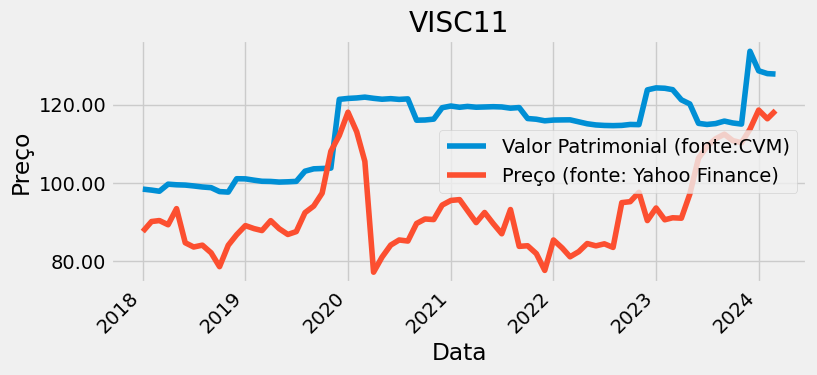

In [15]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize=(8, 3))  # Ajustar o tamanho da figura, se necessário

plt.plot(dados['Data_Referencia'], dados['Valor_Patrimonial_Cotas'], label='Valor Patrimonial (fonte:CVM)')
plt.plot(dados['Data_Referencia'], dados['preco'], label='Preço (fonte: Yahoo Finance)')

plt.xlabel('Data')
plt.ylabel('Preço')
plt.title(fundo.upper())

plt.xticks(rotation=45, ha='right')  # Inclinar os labels do eixo x
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))  # Duas casas decimais no eixo y


plt.grid(True)
plt.legend()
plt.show()

In [16]:
import plotly.graph_objects as go
trace1 = go.Scatter( x=dados['Data_Referencia'], y=dados['Valor_Patrimonial_Cotas'],
                     name='Valor Patrimonial da cota (fonte: CVM)', mode='lines')
trace2 = go.Scatter( x=dados['Data_Referencia'], y=dados['preco'],
                     name='Preço (fonte: Yahoo Finance)', mode='lines')
layout = go.Layout(title=fundo.upper(), xaxis=dict( title='Data', tickangle=45 ),
                   yaxis=dict( title='Preço', tickformat='.2f' ),
                   legend=dict(orientation="h" ) )
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()